In [103]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

In [104]:
#load LDA labels from CSV
lda_df = pd.read_csv("BA_Airline_NegativeReviews_with_LDA.csv")
lda_df = lda_df[['ReviewBody', 'review_topics']].dropna()

#load Label Studio annotations
with open("Merged_LabelStudio_Annotations.json", "r") as f:
    ls_data = json.load(f)

#extract labels from Label Studio data
ls_records = []
for item in ls_data:
    review_text = item["data"]["ReviewBody"]
    labels = []
    for result in item["annotations"][0]["result"]:
        labels.extend(result["value"]["labels"])
    labels = list(set(labels))  # remove duplicates
    ls_records.append({"ReviewBody": review_text, "manual_labels": labels})

ls_df = pd.DataFrame(ls_records)

#merge datasets on ReviewBody
merged_df = pd.merge(ls_df, lda_df, on="ReviewBody", how="inner")

#convert string representation of list to actual list for LDA topics
merged_df["review_topics"] = merged_df["review_topics"].apply(lambda x: eval(x) if isinstance(x, str) else [])
mlb = MultiLabelBinarizer()

#create a consistent label encoding for both sets
manual_encoded = mlb.fit_transform(merged_df["manual_labels"])
lda_encoded = mlb.transform(merged_df["review_topics"])

#reduce multi-label to single-label via argmax for ARI/NMI (approximation)
manual_single = manual_encoded.argmax(axis=1)
lda_single = lda_encoded.argmax(axis=1)

#compute evaluation metrics
ari = adjusted_rand_score(manual_single, lda_single)
nmi = normalized_mutual_info_score(manual_single, lda_single)

ari, nmi

(0.03632691059269407, 0.08247956372262132)

In [105]:
merged_df["manual_labels"][0]

['Baggage Problems',
 'Airline Staff & Ground Services',
 'Flight Delays & Cancellations']

In [106]:
merged_df["review_topics"][0]

['Overpriced & Poor Value for Money',
 'Flight Delays & Cancellations',
 'Refund & Compensation Disputes',
 'Baggage Problems']

In [107]:
labels = mlb.classes_
labels

array(['Accessibility and special assistance',
       'Airline Staff & Ground Services', 'Baggage Problems',
       'Booking & Check-in Issues', 'Flight Delays & Cancellations',
       'Food and Beverage', 'In-Flight Experience Issues',
       'Loyalty Program and benefits',
       'Overpriced & Poor Value for Money',
       'Refund & Compensation Disputes', 'Safety & Security Concerns',
       'Seating Comfort'], dtype=object)

In [108]:
#get all label names
labels = mlb.classes_

#create multilabel binary arrays
manual_bin = mlb.transform(merged_df["manual_labels"])
lda_bin = mlb.transform(merged_df["review_topics"])

#generate multilabel classification report
report = classification_report(manual_bin, lda_bin, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

report_df.round(3)  # round for readability


,precision,recall,f1-score,support
Accessibility and special assistance,0.000,0.000,0.000,32.0
Airline Staff & Ground Services,0.497,0.228,0.312,404.0
Baggage Problems,0.275,0.764,0.404,148.0
Booking & Check-in Issues,0.000,0.000,0.000,155.0
Flight Delays & Cancellations,0.448,0.472,0.459,318.0
Food and Beverage,0.578,0.895,0.703,437.0
In-Flight Experience Issues,0.000,0.000,0.000,423.0
Loyalty Program and benefits,0.000,0.000,0.000,81.0
Overpriced & Poor Value for Money,0.228,0.704,0.345,199.0
Refund & Compensation Disputes,0.325,0.737,0.451,152.0


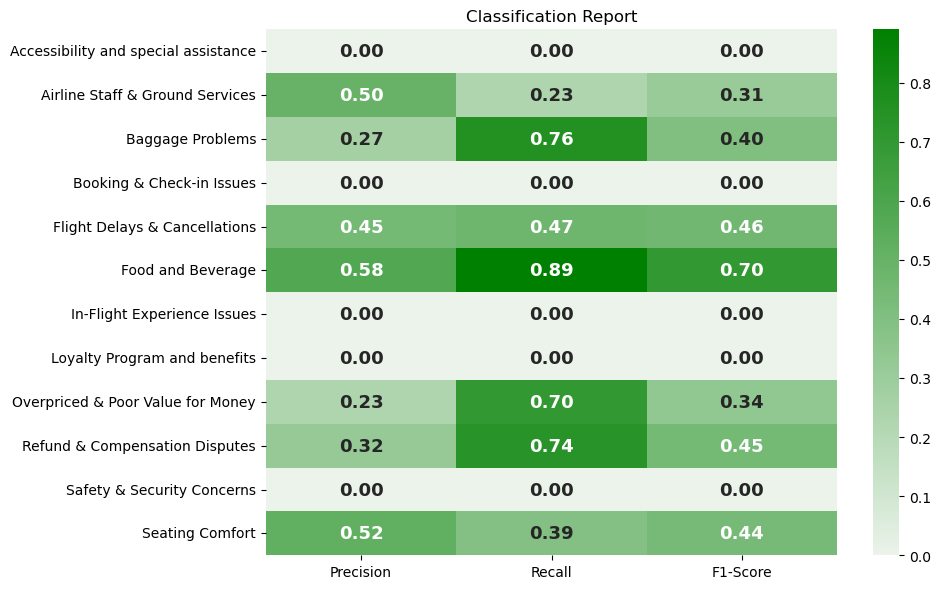

In [109]:
# Calculate metrics
precision, recall, f1, _ = precision_recall_fscore_support(manual_bin, lda_bin, average=None)

# Create DataFrame for heatmap
metrics_df = pd.DataFrame({
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1
}, index=labels)

# Round to 2 decimal places for display
metrics_df = metrics_df.round(2)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap=sns.light_palette("green", as_cmap=True), fmt='.2f', annot_kws={"size": 13, "weight": "bold"})
plt.title("Classification Report")
#plt.ylabel("Labels")
plt.tight_layout()
plt.show()


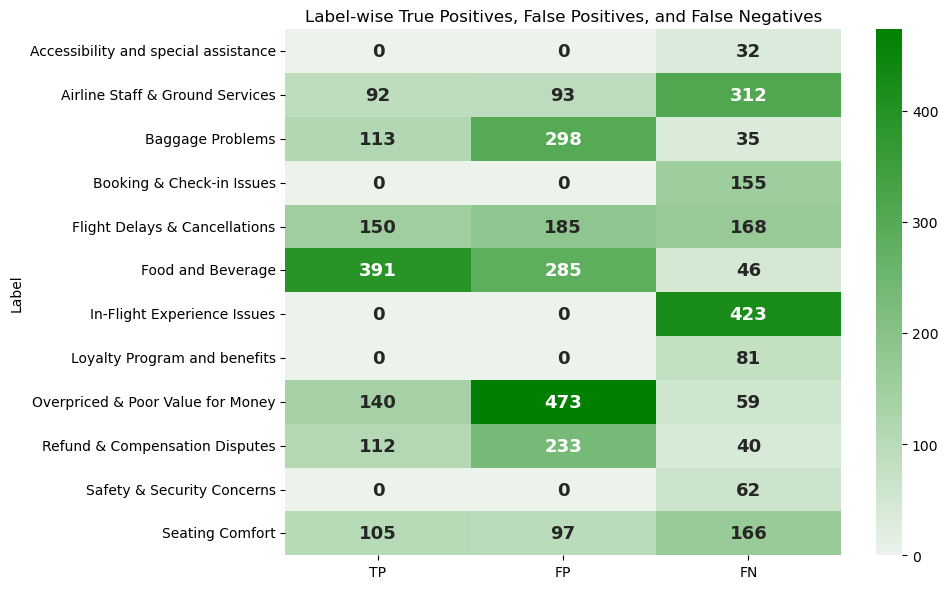

In [110]:
#compute multilabel confusion matrix
conf_matrix = multilabel_confusion_matrix(manual_bin, lda_bin)

#sum true positives per label (diagonal of each confusion matrix)
true_positives = [m[1, 1] for m in conf_matrix]
false_positives = [m[0, 1] for m in conf_matrix]
false_negatives = [m[1, 0] for m in conf_matrix]

#create heatmap-compatible matrix
conf_data = pd.DataFrame({
    "Label": labels,
    "TP": true_positives,
    "FP": false_positives,
    "FN": false_negatives
}).set_index("Label")

#plot as a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(conf_data, annot=True, cmap=sns.light_palette("green", as_cmap=True), fmt='g', annot_kws={"size": 13, "weight": "bold"})
plt.title("Label-wise True Positives, False Positives, and False Negatives")
plt.ylabel("Label")
plt.tight_layout()
plt.show()


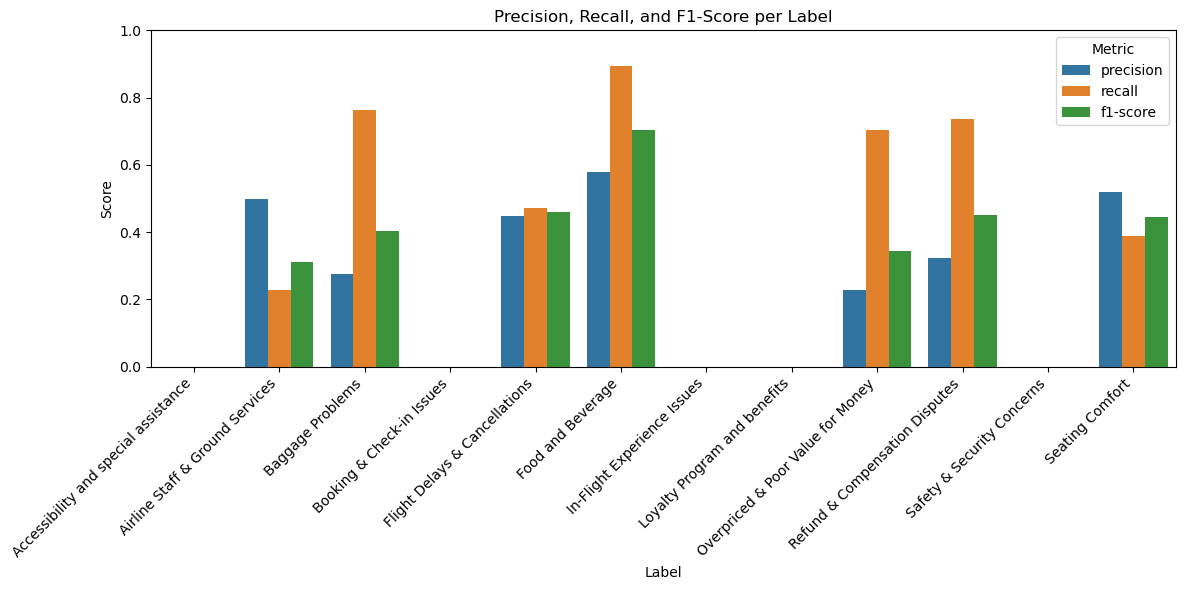

In [111]:
#prepare data for bar plot
prf_df = report_df.loc[labels, ["precision", "recall", "f1-score"]].reset_index().rename(columns={"index": "Label"})
prf_melted = prf_df.melt(id_vars="Label", var_name="Metric", value_name="Score")

#plot precision, recall, f1-score per label
plt.figure(figsize=(12, 6))
sns.barplot(data=prf_melted, x="Label", y="Score", hue="Metric")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.title("Precision, Recall, and F1-Score per Label")
plt.tight_layout()
plt.show()


In [112]:
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

precision = precision_score(manual_bin, lda_bin, average='samples')
recall = recall_score(manual_bin, lda_bin, average='samples')
f1 = f1_score(manual_bin, lda_bin, average='samples')
jaccard = jaccard_score(manual_bin, lda_bin, average='samples')

print(f"Precision@k: {precision:.4f}")
print(f"Recall@k: {recall:.4f}")
print(f"F1@k: {f1:.4f}")
print(f"Jaccard Similarity: {jaccard:.4f}")


Precision@k: 0.4217
Recall@k: 0.4173
F1@k: 0.3830
Jaccard Similarity: 0.2753
